## Goal

Build a ReAct architecture that takes feedback from the tool calls.
- Use a prebuilt `ToolNode` and pass in the list of tools.
- Use `tools_condition` edge to route the llm's output.
- If the llm calls the tool, send the feedback to llm and repeat.

In [2]:
# general imports
import sys
import os, getpass
from openai import OpenAI
from utils import *
from IPython.display import Image
from pprint import pprint

# Import langgraph modules to create and visualize the graph
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage 
from typing_extensions import TypedDict
from typing import Literal
from pydantic import BaseModel, Field

# Install the missing package
# %pip install langchain_anthropic
# %pip install langchain_groq
from langchain_groq import ChatGroq
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool

In [3]:
# Let's make sure we have the API key set
load_dotenv()
GROQ_API_KEY = set_api_key('GROQ_API_KEY')
ANTHROPIC_API_KEY = set_api_key('ANTHROPIC_API_KEY')

API key found in .env file for GROQ_API_KEY
API key found in .env file for ANTHROPIC_API_KEY


#### Messages

Chat models can use `messages`, which captures different roles within a conversation (e.g., "system", "human", "assistant").
Messages also feature one or more content blocks that contain text or potentially multimodal data (e.g., images, audio, video).

<h5>Let's create a list of messages. Each message can be supplied with a few things:</h5>

- `content` - content of the message
- `name` - optionally, who is creating the message
-  `response_metadata` - optionally, a dict of metadata that is oftern specific to each model provider

In [4]:

messages = [AIMessage(content=f'So you wanted to know more starwars conception idea?', name = 'AI')]
messages.extend([HumanMessage(content=f'Yes, I am interested in starwars', name = 'Human')])
messages.extend([AIMessage(content=f'What do you want to know about starwars?', name = 'AI')])
messages.extend([HumanMessage(content=f'What is the starwars universe?', name = 'Human')])


In [5]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: AI

So you wanted to know more starwars conception idea?
================================ Human Message =================================
Name: Human

Yes, I am interested in starwars
================================== Ai Message ==================================
Name: AI

What do you want to know about starwars?
================================ Human Message =================================
Name: Human

What is the starwars universe?


### Chat Models

Chat models use a sequence of message as input and support message roles.

There are many chat models available out there to choose from, in our case, we will use Groq.

We can load the AI model and invoke it with our list of messages.


In [6]:
ai = ChatGroq(model="llama-3.3-70b-versatile", api_key=GROQ_API_KEY, temperature=0, max_retries=2)

In [7]:
result = ai.invoke(messages)
result.pretty_print()

================================== Ai Message ==================================

The Star Wars universe, also known as the Star Wars galaxy, is a vast, fictional universe created by George Lucas. It's a sprawling, epic space opera that spans thousands of years, numerous planets, and a wide range of alien species, technologies, and cultures.

The Star Wars universe is set in a distant galaxy, where a variety of planets, star systems, and regions are connected by a network of trade routes, hyperspace lanes, and political alliances. The galaxy is home to numerous factions, including:

1. **The Galactic Republic**: A democratic government that spans the galaxy, promoting peace, justice, and cooperation among its member worlds.
2. **The Galactic Empire**: A tyrannical regime that rises from the ashes of the Republic, seeking to dominate and control the galaxy through fear, intimidation, and military might.
3. **The Rebel Alliance**: A coalition of planets and factions that resist Imperial 

In [74]:
result.response_metadata

{'token_usage': {'completion_tokens': 526,
  'prompt_tokens': 90,
  'total_tokens': 616,
  'completion_time': 1.912727273,
  'prompt_time': 0.006402538,
  'queue_time': 0.232141683,
  'total_time': 1.919129811},
 'model_name': 'llama-3.3-70b-versatile',
 'system_fingerprint': 'fp_e669a124b2',
 'finish_reason': 'stop',
 'logprobs': None}

In [8]:
stream = ai.stream(messages)
full = next(stream)
for chunk in stream:
    full += chunk
full.pretty_print()

============================ Aimessagechunk Message ============================

The Star Wars universe, also known as the Star Wars galaxy, is a vast, fictional universe created by George Lucas. It's a sprawling, epic space opera that spans thousands of years, numerous planets, and a wide range of alien species, technologies, and cultures.

The Star Wars universe is set in a distant galaxy, where a variety of planets, star systems, and regions are connected by a network of trade routes, hyperspace lanes, and political alliances. The galaxy is home to numerous factions, including:

1. **The Galactic Republic**: A democratic government that spans the galaxy, promoting peace, justice, and cooperation among its member worlds.
2. **The Galactic Empire**: A tyrannical regime that rises from the ashes of the Republic, seeking to dominate and control the galaxy through fear, intimidation, and military might.
3. **The Rebel Alliance**: A coalition of planets and factions that resist Imperial 

<h4> Tools </h4>

Tools are an additional capability provided to LLMs that can be used to interact with outside world.

It could be leveraged to control different parts of the code, call an external API, interact with database, trigger a lambda function, etc.

Tools can be as simple as Python functions or as complex as integrating LLM with RAG for real time analysis.

In [43]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."


@tool
def get_coolest_cities():
    """Get a list of coolest cities"""
    return "sf, nyc"

In [44]:
ai_tools = ai.bind_tools([get_weather, get_coolest_cities])

In [26]:
tool_call = ai_tools.invoke([HumanMessage(content='What"s the weather in SF?', name='Human')])

In [27]:
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zqp8', 'function': {'arguments': '{"location": "San Francisco"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 267, 'total_tokens': 282, 'completion_time': 0.054545455, 'prompt_time': 0.01397054, 'queue_time': 0.236006884, 'total_time': 0.068515995}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ca0059abb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3a6c33b1-a027-4acc-bb65-f6571e9b6183-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'San Francisco'}, 'id': 'call_zqp8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 267, 'output_tokens': 15, 'total_tokens': 282})

<h5>ToolNode</h5>

It is basically a LangChain Runnable that takes graph state (with a list of messages) as input and outputs state update with the result of tool calls. 

The state must have `messages` channel with an appropriate reducer for ToolNode to work. Multiple tools can be passed to this node.

There are two ways to call `ToolNode` i.e Either manually using an AIMessage or use a ChatModel with bind tools to call ToolNode

If triggered manually, the last AIMessage must contain the `tool_calls` parameter to determine which tool to call. 

If the input is coming from ChatModel, that already contains the `tool_calls` parameter.

In [16]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [17]:
# Let's define an initial state with an initial message
initial_messages= [AIMessage(content='Hello, I am a calculator assistant. I can help you with mathematical operations.', name='AI'),
                   HumanMessage(content='I am looking for information on how to perform exponentiation', name='Human')]

# New message to add
new_message = AIMessage(content='I can help you with that. What is the base number and the exponent number?', name='AI')

# test 
add_messages(initial_messages, new_message)

[AIMessage(content='Hello, I am a calculator assistant. I can help you with mathematical operations.', additional_kwargs={}, response_metadata={}, name='AI', id='44bdbaef-91b6-4b37-9615-e4b274ad3583'),
 HumanMessage(content='I am looking for information on how to perform exponentiation', additional_kwargs={}, response_metadata={}, name='Human', id='27cb371b-7e94-4121-a9cf-7906de708ada'),
 AIMessage(content='I can help you with that. What is the base number and the exponent number?', additional_kwargs={}, response_metadata={}, name='AI', id='b5098d76-665c-4ea1-8d86-19f13474a034')]

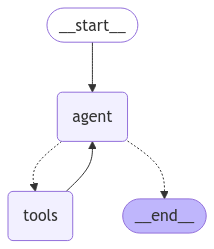

In [46]:
# Since this message update is so common, Langgraph has prebuilt MessagesState
from langgraph.graph import MessagesState # MessagesState and State work equivalently
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
# Let's build our graph

class MessagesState(MessagesState):
    messages: Annotated[list[AnyMessage], add_messages] # we need to add this line to the class to make it a Pydantic model

def should_continue(state: MessagesState):
    messages = state["messages"]
    if messages[-1].tool_calls:
        return 'tools'
    return END

# node function
def model_with_tools(state: MessagesState):
    return {"messages": [ai_tools.invoke(state["messages"])]} # invoke the tool_calling_ai tool

tool_node =ToolNode([get_weather, get_coolest_cities])
# build graph
builder = StateGraph(MessagesState)
builder.add_node('agent', model_with_tools)
builder.add_node('tools', tool_node)
builder.add_edge(START, 'agent')
builder.add_conditional_edges('agent', should_continue, ['tools', END])
builder.add_edge('tools', 'agent')
# builder.add_edge('agent', END)

app = builder.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
message_invoke = app.invoke({"messages" : HumanMessage(content='Hello!')} )
message_invoke

{'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='c354f14f-3ee5-43a7-989a-5baa6b265dde'),
  AIMessage(content='Hello! Is there something I can help you with, or would you like to know the current weather or the coolest cities?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 262, 'total_tokens': 288, 'completion_time': 0.094545455, 'prompt_time': 0.015309591, 'queue_time': 0.264442325, 'total_time': 0.109855046}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_7b42aeb9fa', 'finish_reason': 'stop', 'logprobs': None}, id='run-d5dcfd08-1c05-4ab4-97e4-fd562fa2f731-0', usage_metadata={'input_tokens': 262, 'output_tokens': 26, 'total_tokens': 288})]}

In [ ]:
message_invoke = app.invoke({"messages" :HumanMessage(content = 'You are a weather assitant who has all the tools for answering queries about the weather. Use those tools and use the tools no more than 3 times and tell What"s the weather in sf?')} )
message_invoke

{'messages': [HumanMessage(content='You are a weather assitant who has all the tools for answering queries about the weather. Use those tools and use the tools no more than 3 times and tell What"s the weather in sf?', additional_kwargs={}, response_metadata={}, id='c100fcbb-0ca7-4dc9-959b-ba92206c5938'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7fj2', 'function': {'arguments': '{"location": "San Francisco"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 300, 'total_tokens': 315, 'completion_time': 0.054545455, 'prompt_time': 0.015596899, 'queue_time': 0.298022014, 'total_time': 0.070142354}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_7b42aeb9fa', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-383ea1e2-bbbc-4b7d-b9bf-1685589a8bc6-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'San Francisco'}, 'id': 'call_7fj2', 'type': 'tool_call'

In [ ]:
message_invoke = app.invoke({"messages" :HumanMessage(content = 'You are a weather assitant who has all the tools for answering queries about the weather. Use those tools no more than 3 times and tell me What"s the weather in the coolest cities?')} )
message_invoke

{'messages': [HumanMessage(content='You are a weather assitant who has all the tools for answering queries about the weather. Use those tools no more than 3 times and tell me What"s the weather in the coolest cities?', additional_kwargs={}, response_metadata={}, id='ab0c8f83-98cf-4ab3-9d81-56020d271206'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a08q', 'function': {'arguments': '{}', 'name': 'get_coolest_cities'}, 'type': 'function'}, {'id': 'call_m6ja', 'function': {'arguments': '{"location": "First coolest city"}', 'name': 'get_weather'}, 'type': 'function'}, {'id': 'call_vfsn', 'function': {'arguments': '{"location": "Second coolest city"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 597, 'total_tokens': 639, 'completion_time': 0.152727273, 'prompt_time': 0.030382115, 'queue_time': -0.17712026600000003, 'total_time': 0.183109388}, 'model_name': 'llama-3.3-70b-versatile', 's

In [47]:
for chunk in app.stream({"messages" :HumanMessage(content = 'You are a weather assitant who has all the tools for answering queries about the weather.\
                                                     Use those tools no more than 3 times and tell me What"s the weather in sf?')}, stream_mode = 'values' ):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

You are a weather assitant who has all the tools for answering queries about the weather.                                                     Use those tools no more than 3 times and tell me What"s the weather in sf?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_5383)
 Call ID: call_5383
  Args:
    location: San Francisco
================================= Tool Message =================================
Name: get_weather

It's 60 degrees and foggy.
================================== Ai Message ==================================

The current weather in San Francisco is 60 degrees and foggy.


In [48]:
for chunk in app.stream({"messages" :HumanMessage(content = 'You are a weather assitant who has all the tools for answering queries about the weather.\
                                                     Use those tools no more than 3 times and tell me What"s the weather in the coolest cities?')}, stream_mode = 'values' ):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

You are a weather assitant who has all the tools for answering queries about the weather.                                                     Use those tools no more than 3 times and tell me What"s the weather in the coolest cities?
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (call_434z)
 Call ID: call_434z
  Args:
  get_weather (call_n3ym)
 Call ID: call_n3ym
  Args:
    location: coolest city
  get_weather (call_c327)
 Call ID: call_c327
  Args:
    location: coolest city
================================= Tool Message =================================
Name: get_weather

It's 90 degrees and sunny.
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_szpx)
 Call ID: call_szpx
  Args:
    location: San Francisco
================================= Tool Message ====================

We can see here the model is not that smart to understand that get_coolest_cities has 'nyc','sf' as arguments, instead the model used the argument as 'location':'coolest city' with AI sending the call to tool.

If we don't explicitly tell the model to not iterate more than 3 times, it goes into graph recursion error, which is dangerous because each call to the model consumes your API calls. 